# Setup

In [8]:
!pip install transformers
!pip install datasets

In [9]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# constants and global variables
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/MLHC/Project2/Dataset/{}'
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/MLHC/Project2/Models/{}'

is_train_enabled = False
use_bert_base_cased = False

# Utils

In [12]:
# go from string labels to int labels
from tensorflow.keras.utils import to_categorical

labels = ['BACKGROUND', "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"]

# map each label to an integer
mapping = {}
for x in range(len(labels)):
  mapping[labels[x]] = x

def from_label_to_integer(y):
  for x in range(len(y)):
    y[x] = int(mapping[y[x].strip("\n")])
  

  return np.argmax(np.array(to_categorical(y)), axis=-1)


# Read Data and perform Tokenization

In [13]:
from datasets import Dataset


# read the dataset
train = open(DATA_PATH.format("train.txt"), "r").readlines()
test = open(DATA_PATH.format("test.txt"), "r").readlines()
dev = open(DATA_PATH.format("dev.txt"), "r").readlines()

# Remove ID and empty lines
train = list(filter(lambda x: not x.startswith(('###', '\n')), train))
test = list(filter(lambda x: not x.startswith(('###', '\n')), test))
dev = list(filter(lambda x: not x.startswith(('###', '\n')), dev))

# Build list of sentences and label
train = list(map(lambda x: x.split('\t', 1), train))
test = list(map(lambda x: x.split('\t', 1), test))
dev = list(map(lambda x: x.split('\t', 1), dev))

# Lowercase sentences
train = list(map(lambda x:[x[0], x[1].lower()], train))
test = list(map(lambda x:[x[0], x[1].lower()], test))
dev = list(map(lambda x:[x[0], x[1].lower()], dev))

# split labels from data and change string labels to integers
y_train = from_label_to_integer(list(map(lambda x:x[0], train)))
train = list(map(lambda x:x[1], train))

y_test = from_label_to_integer(list(map(lambda x:x[0], test)))
test = list(map(lambda x:x[1], test))

y_dev = from_label_to_integer(list(map(lambda x:x[0], dev)))
dev = list(map(lambda x:x[1], dev))

# go from list type to 'Dataset' type. This object is requiered to train the model
df = pd.DataFrame(train, columns =['Phrase'])
train = Dataset.from_pandas(df).add_column(name="Label", column=y_train)

df = pd.DataFrame(test, columns =['Phrase'])
test = Dataset.from_pandas(df).add_column(name="Label", column=y_test)

df = pd.DataFrame(dev, columns =['Phrase'])
dev = Dataset.from_pandas(df).add_column(name="Label", column=y_dev)

for i in range(5):
  print(train[i])

{'Phrase': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n', 'Label': 0}
{'Phrase': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .\n', 'Label': 0}
{'Phrase': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .\n', 'Label': 2}
{'Phrase': "the intervention group will participate in the online group program ` positive outlook ' .\n", 'Label': 2}
{'Phrase': 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .\n', 'Label': 2}


In [14]:
# compute the average length of phrases
tmp = np.array(list(map(lambda phrase: len(phrase["Phrase"].split()),train)))
print(tmp.mean())
print(np.median(tmp))

tmp = np.array(list(map(lambda phrase: len(phrase["Phrase"].split()),test)))
print(tmp.mean())
print(np.median(tmp))

tmp = np.array(list(map(lambda phrase: len(phrase["Phrase"].split()),dev)))
print(tmp.mean())
print(np.median(tmp))


26.229355280462922
23.0
25.999660936493406
23.0
26.412173372044794
23.0


In [15]:
# perform tokenizationn of the dataset for BERT models
from transformers import AutoTokenizer

if use_bert_base_cased:
  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
else:
  tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def tokenize_function(sentence):
    return tokenizer(sentence['Phrase'], padding=True, truncation=True, max_length=30)

train = train.map(tokenize_function, batched=True)
test = test.map(tokenize_function, batched=True)
dev = dev.map(tokenize_function, batched=True)

for i in range(5):
  print(train[i])

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

  0%|          | 0/2212 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/29 [00:00<?, ?ba/s]

{'Phrase': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n', 'Label': 0, 'input_ids': [101, 1103, 15351, 1104, 20844, 1964, 1112, 170, 13306, 3879, 2086, 1115, 1234, 1690, 1114, 20844, 1964, 1132, 2320, 1106, 1321, 1167, 4812, 1111, 1103, 2191, 118, 2635, 1104, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'Phrase': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .\n', 'Label': 0, 'input_ids': [101, 1142, 2526, 4856, 1103, 1902, 1105, 10540, 1104, 3112, 25059, 117, 1126, 3294, 1788, 14485, 1106, 11778, 1103, 2191, 118, 

In [16]:
# go from 'Dataset' type to tensorflow so that our dataset can be used for training in keras
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = train.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["Label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=64,
)

tf_test_dataset = test.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["Label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=64,
)

tf_validation_dataset = dev.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["Label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=64,
)

# BERT MODELS

## PRE-TRAINED fine tuning

In [17]:
from transformers import TFAutoModelForSequenceClassification

# Compute some variables needed to speed up training
train_steps_per_epoch = int(len(tf_train_dataset) * (100/100) / 64)
dev_steps_per_epoch = int(len(tf_validation_dataset) * (100/100) / 64)


# download pre-trained model
if use_bert_base_cased:
  model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
else:
  model = TFAutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=5, from_pt=True)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if is_train_enabled:
  model.fit(tf_train_dataset,
            validation_data=tf_validation_dataset,
            epochs=20,
            verbose=2,
            steps_per_epoch=train_steps_per_epoch,
            validation_steps=dev_steps_per_epoch,)
  
  if use_bert_base_cased:
    model.save_pretrained(MODEL_PATH.format("bert_base_cased"))
  else:
    model.save_pretrained(MODEL_PATH.format("bert_clinical"))

In [ ]:
# load the model from the corresposning h5 file
if use_bert_base_cased:
  model.load_weights(MODEL_PATH.format("bert_base_cased/tf_model.h5"))
else:
  model.load_weights(MODEL_PATH.format("bert_clinical/tf_model.h5"))

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

y_pred = model.predict(tf_test_dataset)
y_pred = np.argmax(np.array(y_pred[0]), axis=-1)

f1 = f1_score(y_test, y_pred, average="macro")

print("Test f1 score : %s "% f1)

f1_w = f1_score(y_test, y_pred, average="weighted")

print("Test f1 weighted score : %s "% f1_w)

acc = accuracy_score(y_test, y_pred)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.8081964131253725 
Test f1 weighted score : 0.8658812855788833 
Test accuracy score : 0.8667141355575899 


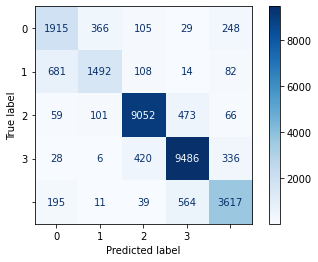

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()